In [140]:
import os
import sys
import yaml
import tifffile
from pathlib import Path

import numpy as np
from scipy import ndimage
import math
import random

import SimpleITK as sitk
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image

sys.path.append(os.path.abspath(os.path.join('..')))

import src.gui as gui

In [2]:
data_path = Path('../data/')

In [145]:
vol = tifffile.imread(data_path / '1099_scale.tif')
label = tifffile.imread(data_path / '1099_brain_clean_scale.tif')

TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'


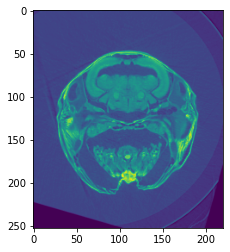

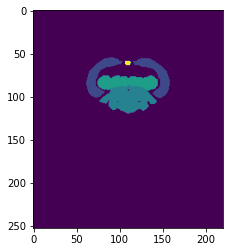

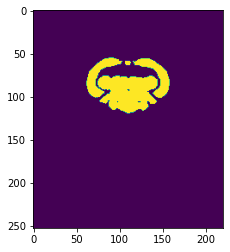

1


In [149]:
slice_num = 143

plt.imshow(vol[slice_num])
plt.show()

plt.imshow(label[slice_num])
plt.show()

#print(vol.dtype)
#print(label.dtype)

# Remove optic nerve, with label ID=1
label[label == 1] = 0

label_merged = (label > 0).astype(int)
plt.imshow(label_merged[slice_num])
plt.show()

print(np.max(label_merged))

In [163]:
def align_to_oriented_bounding_box(image, shape_stats, is_label=False):

    resampler = sitk.ResampleImageFilter()
    aligned_image_spacing = [1,1,1] #in nanometers

    label_num = 1

    aligned_image_size = [ int(ceil(shape_stats.GetOrientedBoundingBoxSize(label_num)[i]/aligned_image_spacing[i])) for i in range(3) ]

    #print(aligned_image_size)

    direction_mat = shape_stats.GetOrientedBoundingBoxDirection(label_num)
    aligned_image_direction = [direction_mat[0], direction_mat[3], direction_mat[6], 
                               direction_mat[1], direction_mat[4], direction_mat[7],
                               direction_mat[2], direction_mat[5], direction_mat[8] ]

    #print(aligned_image_direction)

    resampler.SetOutputDirection(aligned_image_direction)
    resampler.SetOutputOrigin(shape_stats.GetOrientedBoundingBoxOrigin(label_num))
    resampler.SetOutputSpacing(aligned_image_spacing)
    resampler.SetSize(aligned_image_size)
    
    if is_label:
        resample_mode = sitk.sitkNearestNeighbor
    else:
        resample_mode = sitk.sitkLinear
        
    resampler.SetInterpolator(resample_mode)

    #print(direction_mat)

    obb_img = resampler.Execute(image)
    
    return obb_img
    #obb_label = resampler.Execute(itk_label)
    
def get_brain_centroids(np_label):
    
    label_tectum = np_label.copy()
    label_midbrain = np_label.copy()
    label_forebrain = np_label.copy()

    # Keep only tectum
    label_tectum[label_tectum != 2] = 0
    label_tectum[label_tectum == 2] = 1

    # Keep only midbrain
    label_midbrain[label_midbrain != 4] = 0
    label_midbrain[label_midbrain == 4] = 1
    
    # Keep only forebrain
    label_forebrain[label_forebrain != 3] = 0
    label_forebrain[label_forebrain == 3] = 1
    
    itk_tectum_label = sitk.GetImageFromArray(label_tectum)
    itk_midbrain_label = sitk.GetImageFromArray(label_midbrain)
    itk_forebrain_label = sitk.GetImageFromArray(label_forebrain)

    shape_stats = sitk.LabelShapeStatisticsImageFilter()
    shape_stats.ComputeOrientedBoundingBoxOn()

    shape_stats.Execute(itk_tectum_label)
    centroid_tectum = shape_stats.GetCentroid(1)

    shape_stats.Execute(itk_midbrain_label)
    centroid_midbrain = shape_stats.GetCentroid(1)
    
    shape_stats.Execute(itk_forebrain_label)
    centroid_forebrain = shape_stats.GetCentroid(1)
    
    return centroid_tectum, centroid_midbrain, centroid_forebrain


def align_volume_and_label(vol, label, remove_list = []):
    
    # Remove optic nerve, with label ID=1
    label[label == 1] = 0

    # Merge all labels to compute the bounding box
    label_merged = (label > 0).astype(int)
    
    itk_label = sitk.GetImageFromArray(label_rot)
    itk_label_merged = sitk.GetImageFromArray(label_merged_rot)
    itk_img = sitk.GetImageFromArray(vol)

    shape_stats = sitk.LabelShapeStatisticsImageFilter()
    shape_stats.ComputeOrientedBoundingBoxOn()
    shape_stats.Execute(itk_label_merged)
    
    obb_label = align_to_oriented_bounding_box(itk_label, shape_stats, is_label=True)
    obb_img = align_to_oriented_bounding_box(itk_img, shape_stats, is_label=False)
    
    np_label = sitk.GetArrayViewFromImage(obb_label)
    np_img = sitk.GetArrayViewFromImage(obb_img)
    
    centroid_tectum, centroid_midbrain, centroid_forebrain = get_brain_centroids(np_label)
    
    dist_threshold = 10

    centroid_tectum_x = centroid_tectum[0]
    centroid_tectum_y = centroid_tectum[1]
    centroid_tectum_z = centroid_tectum[2]

    centroid_midbrain_x = centroid_midbrain[0]
    centroid_midbrain_y = centroid_midbrain[1]
    
    centroid_forebrain_z = centroid_forebrain[2]
    
    # Correct orientation of data based on spatial positions of forebrain, midbrain and tectum   
    if centroid_midbrain_x - centroid_tectum_x > dist_threshold and math.fabs(centroid_midbrain_y - centroid_tectum_y) < dist_threshold:
        np_label = np.rot90(np_label, axes=(1,2), k=-1)
        np_img = np.rot90(np_img, axes=(1,2), k=-1)
        #print('Rotate 90 right')

    if centroid_tectum_x - centroid_midbrain_x > dist_threshold and math.fabs(centroid_midbrain_y - centroid_tectum_y) < dist_threshold:
        np_label = np.rot90(np_label, axes=(1,2))
        np_img = np.rot90(np_img, axes=(1,2))
        #print('Rotate 90 left')

    #if math.fabs(centroid_tectum_x - centroid_midbrain_x) < dist_threshold and centroid_tectum_y - centroid_midbrain_y > dist_threshold:
        #print('Flip vertically')
        
    if centroid_forebrain_z > centroid_tectum_z:
        np_label = np.flip(np_label, axis=0)
        np_img = np.flip(np_img, axis=0)
        #print('Reverse order in Z')
        
    centroids_dict = {}
    centroids_dict['tectum'] = centroid_tectum
    centroids_dict['midbrain'] = centroid_midbrain
    centroids_dict['forebrain'] = centroid_forebrain
    
        
    return np_img, np_label, centroids_dict
        
        

def save_np_sequence_as_multitiff_stack(images, file_name):
    
    imlist = []
    for i in range(len(images)):
        imlist.append(Image.fromarray(images[i]))

    imlist[0].save(file_name, save_all=True, append_images=imlist[1:])
    
    del imlist

In [136]:
itk_label = sitk.GetImageFromArray(label)
itk_label_merged = sitk.GetImageFromArray(label_merged)
itk_img = sitk.GetImageFromArray(vol)

shape_stats = sitk.LabelShapeStatisticsImageFilter()

shape_stats.ComputeOrientedBoundingBoxOn()
#shape_stats.ComputeFeretDiameterOn()

shape_stats.Execute(itk_label_merged)

In [137]:
obb_img = align_to_oriented_bounding_box(itk_img, shape_stats)
obb_label = align_to_oriented_bounding_box(itk_label, shape_stats, is_label=True)


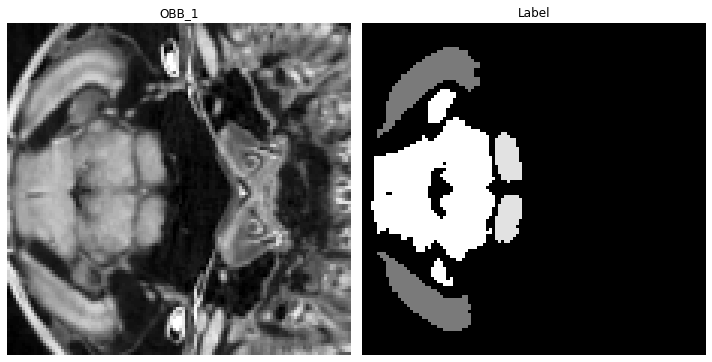

In [138]:

# Change the image axes order so that we have a nice display.
#obb_img = sitk.PermuteAxes(obb_img,[2,1,0])
#obb_label = sitk.PermuteAxes(obb_label,[2,1,0])

gui.MultiImageDisplay(image_list = [obb_img, obb_label],                   
                      title_list = ["OBB_{0}".format(label_num), 'Label'])

(240, 110, 114)


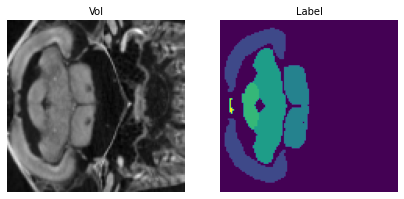

In [139]:
# Display the image slice from the middle of the stack, z axis
z = 110
np_img = sitk.GetArrayViewFromImage(obb_img)
np_label = sitk.GetArrayViewFromImage(obb_label)

print(np_img.shape)


img_slice = np_img[z,:,:]
img_label = np_label[z,:,:]

# Three plots displaying the same data, how do we deal with the high dynamic range?
fig = plt.figure(figsize=(7,7))

fig.add_subplot(1,2,1)
plt.imshow(np.flipud(img_slice), cmap='gray')
plt.title('Vol', fontsize=10)
plt.axis('off')

fig.add_subplot(1,2,2)
plt.imshow(np.flipud(img_label));
plt.title('Label', fontsize=10)
plt.axis('off')

save_np_sequence_as_multitiff_stack(np_img, 'res_img.tif')
save_np_sequence_as_multitiff_stack(np_label, 'res_label.tif')

In [109]:
im = Image.fromarray(img_label.T)
im.save("image.tif")

In [111]:
centroid_tectum, centroid_midbrain = get_centroids_tectum_and_midbrain(np_label)

In [112]:
print(centroid_tectum)
print(centroid_midbrain)

(22.441004985951636, 55.351127929449596, 96.51975703636334)
(44.14536732505951, 54.78680064688459, 89.8591208911017)


In [113]:
dist_threshold = 10

centroid_tectum_x = centroid_tectum[0]
centroid_tectum_y = centroid_tectum[1]

centroid_midbrain_x = centroid_midbrain[0]
centroid_midbrain_y = centroid_midbrain[1]

if centroid_midbrain_x - centroid_tectum_x > dist_threshold and math.fabs(centroid_midbrain_y - centroid_tectum_y) < dist_threshold:
    print('Rotate 90 right')
    
if centroid_tectum_x - centroid_midbrain_x > dist_threshold and math.fabs(centroid_midbrain_y - centroid_tectum_y) < dist_threshold:
    print('Rotate 90 left')
    
if math.fabs(centroid_tectum_x - centroid_midbrain_x) < dist_threshold and centroid_tectum_y - centroid_midbrain_y > dist_threshold:
    print('Flip vertically')   

Rotate 90 right


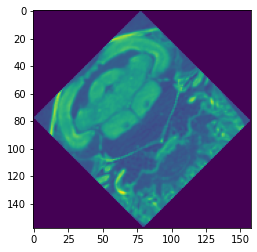

In [114]:
full_img_45 = ndimage.rotate(np_img, -45, axes=(1,2), reshape=True)

plt.imshow(full_img_45[z])
plt.show()

# Testing, Rotations

Angles:  -1 37 29
Rotate 90 left
Reverse order in Z
Rot shape (488, 415, 407)


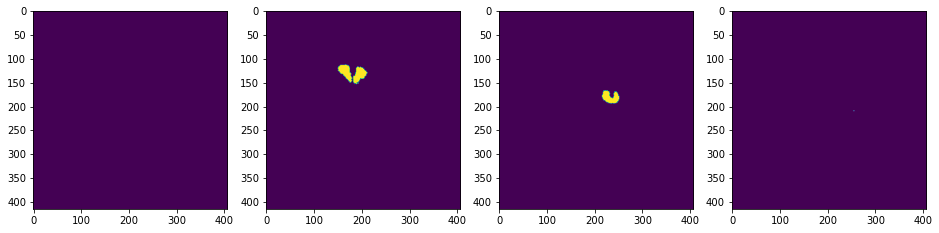

Bbox shape (242, 115, 111)


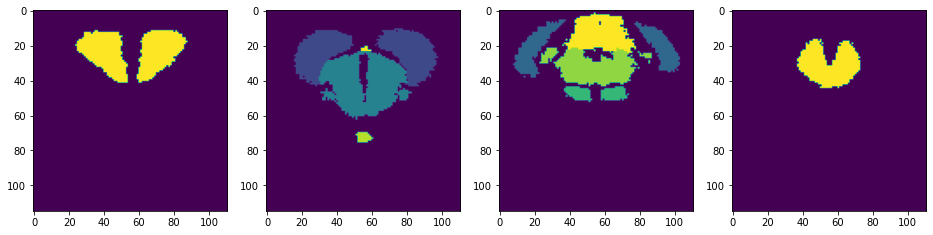

Angles:  -82 -39 34
Rotate 90 left
Rot shape (514, 416, 473)


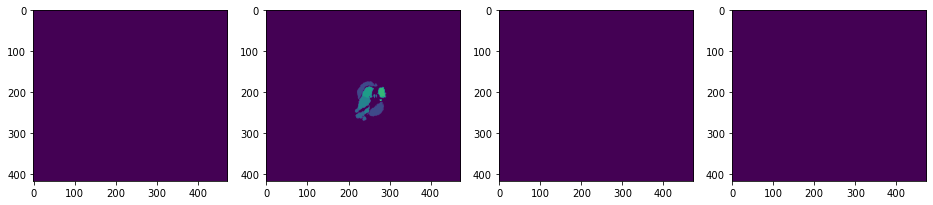

Bbox shape (241, 116, 111)


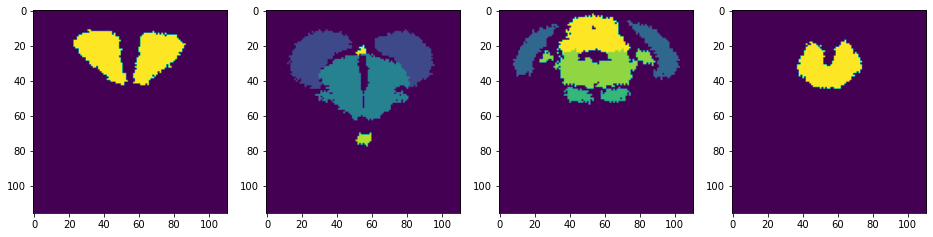

Angles:  -107 36 -11
Rotate 90 left
Reverse order in Z
Rot shape (499, 435, 387)


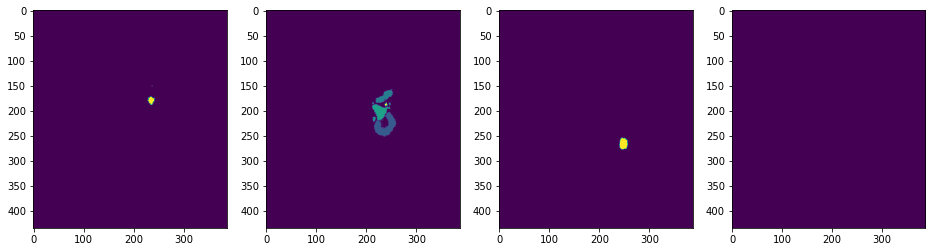

Bbox shape (241, 116, 112)


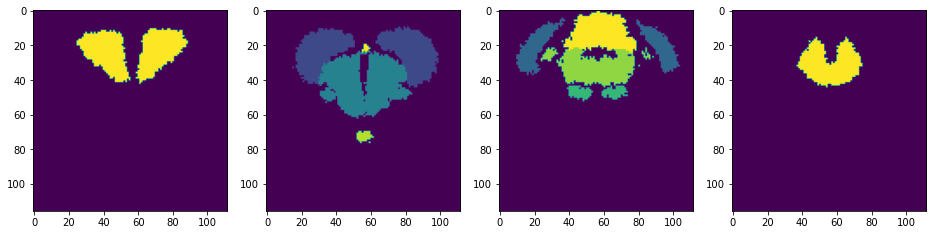

Angles:  81 -36 22
Rotate 90 right
Reverse order in Z
Rot shape (508, 413, 426)


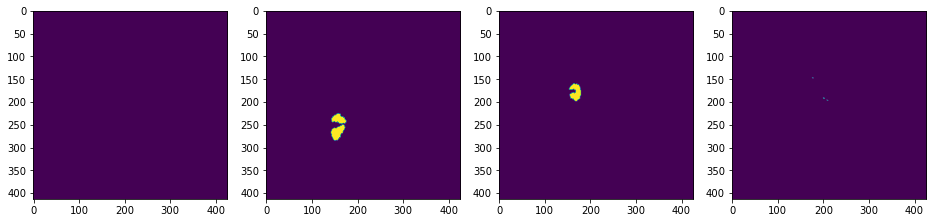

Bbox shape (241, 115, 112)


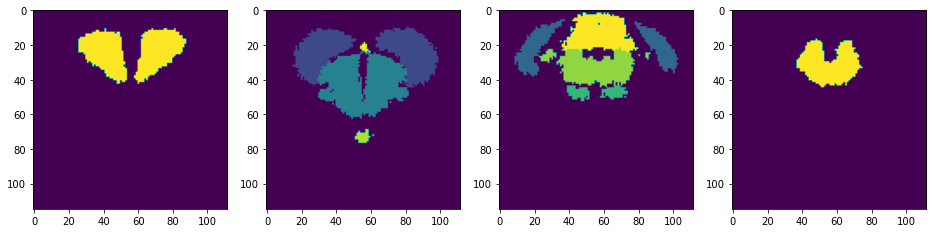

Angles:  11 -10 -9
Rotate 90 left
Rot shape (430, 347, 323)


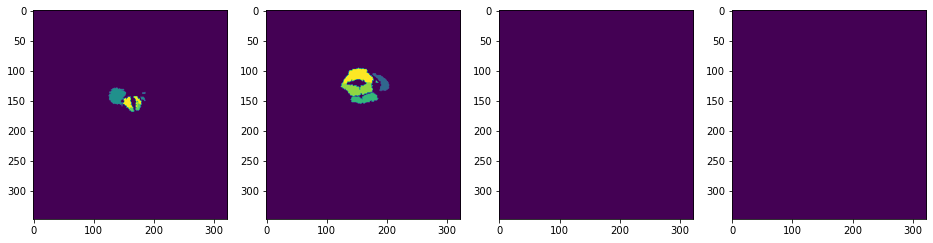

Bbox shape (241, 116, 111)


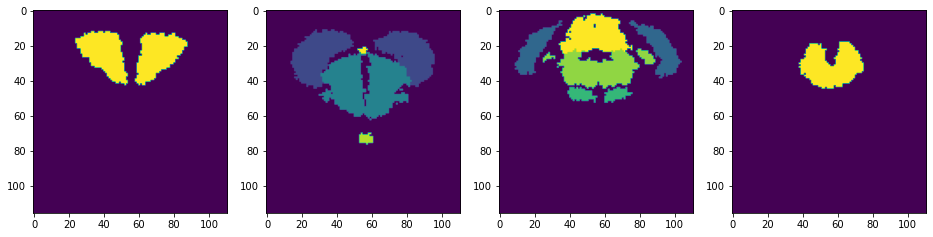

Finished


In [166]:
for i in range(5):
    
    #label_merged_rot = ndimage.rotate(label_merged, a, axes=(1,2), order=0, reshape=True)
    
    a1 = random.randint(-180, 180)
    a2 = random.randint(-45, 45)
    a3 = random.randint(-45, 45)
    
    print('Angles: ', a1, a2, a3)
    
    label_rot = ndimage.rotate(label, a1, axes=(1,2), order=0, reshape=True)
    label_rot = ndimage.rotate(label_rot, a2, axes=(1,0), order=0, reshape=True)
    label_rot = ndimage.rotate(label_rot, a3, axes=(2,0), order=0, reshape=True)
    
    label_merged_rot = ndimage.rotate(label_merged, a1, axes=(1,2), order=0, reshape=True)
    label_merged_rot = ndimage.rotate(label_merged_rot, a2, axes=(1,0), order=0, reshape=True)
    label_merged_rot = ndimage.rotate(label_merged_rot, a3, axes=(2,0), order=0, reshape=True)
    
    itk_label = sitk.GetImageFromArray(label_rot)
    itk_label_merged = sitk.GetImageFromArray(label_merged_rot)
    #itk_img = sitk.GetImageFromArray(vol)

    shape_stats = sitk.LabelShapeStatisticsImageFilter()

    shape_stats.ComputeOrientedBoundingBoxOn()
    #shape_stats.ComputeFeretDiameterOn()

    shape_stats.Execute(itk_label_merged)
    
    obb_label = align_to_oriented_bounding_box(itk_label, shape_stats, is_label=True)
    
    np_label = sitk.GetArrayViewFromImage(obb_label)
    
    centroid_tectum, centroid_midbrain, centroid_forebrain = get_centroids_tectum_and_midbrain(np_label)
    
    dist_threshold = 10

    centroid_tectum_x = centroid_tectum[0]
    centroid_tectum_y = centroid_tectum[1]
    centroid_tectum_z = centroid_tectum[2]

    centroid_midbrain_x = centroid_midbrain[0]
    centroid_midbrain_y = centroid_midbrain[1]
    
    centroid_forebrain_z = centroid_forebrain[2]
    
    

    if centroid_midbrain_x - centroid_tectum_x > dist_threshold and math.fabs(centroid_midbrain_y - centroid_tectum_y) < dist_threshold:
        np_label = np.rot90(np_label, axes=(1,2), k=-1)
        print('Rotate 90 right')

    if centroid_tectum_x - centroid_midbrain_x > dist_threshold and math.fabs(centroid_midbrain_y - centroid_tectum_y) < dist_threshold:
        np_label = np.rot90(np_label, axes=(1,2))
        print('Rotate 90 left')

    if math.fabs(centroid_tectum_x - centroid_midbrain_x) < dist_threshold and centroid_tectum_y - centroid_midbrain_y > dist_threshold:
        print('Flip vertically')
        
    if centroid_forebrain_z > centroid_tectum_z:
        np_label = np.flip(np_label, axis=0)
        print('Reverse order in Z')
        
        
        
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(16, 4))
    print('Rot shape', label_rot.shape)
    ax1.imshow(label_rot[150])
    ax2.imshow(label_rot[200])
    ax3.imshow(label_rot[300])
    ax4.imshow(label_rot[350])
    plt.show()
    
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(16, 4))
    print('Bbox shape', np_label.shape)
    ax1.imshow(np_label[40])
    ax2.imshow(np_label[80])
    ax3.imshow(np_label[120])
    ax4.imshow(np_label[160])
    plt.show()
    
    
    #z = 100
    #plt.imshow(np_label[z])
    #plt.show()
    
print('Finished')
    

In [143]:
random.randint(-45, 45)

12